# Field rasterization inspection


In [1]:
%reload_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

from tqdm.auto import tqdm
import numpy as np
import pandas as pd

from eolearn.core import EOPatch, FeatureType

## 1. Loading the data

In [3]:
# location of directory to which data has been downloaded
ROOT_DATA_DIR = '/mnt/azrael/spatialdata/projects/eo_data/iclr-2020-challange/mlhub'

In [4]:
eopatch_dir = os.path.join(ROOT_DATA_DIR, 'eopatches')
eopatches = sorted(os.listdir(eopatch_dir))
len(eopatches)

80

We will only load the CROP_ID and FIELD_ID masks to perform initial analysis.

In [5]:
crop_ids = []
field_ids = []
for eopatch_p in tqdm(eopatches):
    eopatch = EOPatch.load(os.path.join(eopatch_dir, eopatch_p), 
                           features=[(FeatureType.MASK_TIMELESS, 'CROP_ID'),
                                     (FeatureType.MASK_TIMELESS, 'FIELD_ID')])
    crop_ids.append(eopatch.mask_timeless['CROP_ID'][...,0])
    field_ids.append(eopatch.mask_timeless['FIELD_ID'][...,0])
    
crop_ids = np.stack(crop_ids)
field_ids = np.stack(field_ids)

In [6]:
crop_ids.shape, field_ids.shape

((80, 607, 504), (80, 607, 504))

## 2. Visualization

In [7]:
fields = [np.unique(p) for p in field_ids]

In [8]:
np.argmax([len(f) for f in fields])

69

In [9]:
fields[69]

array([   0,   23,   30,   44,   46,   66,  121,  143,  154,  162,  169,
        196,  197,  201,  203,  205,  214,  223,  237,  241,  251,  252,
        254,  261,  265,  280,  292,  293,  294,  298,  300,  320,  331,
        352,  364,  367,  373,  377,  380,  382,  384,  388,  392,  394,
        395,  396,  397,  401,  404,  409,  417,  419,  422,  424,  438,
        445,  448,  462,  463,  465,  476,  481,  494,  495,  499,  508,
        514,  516,  518,  520,  521,  525,  527,  533,  537,  538,  540,
        543,  549,  552,  553,  554,  555,  560,  563,  570,  571,  573,
        575,  577,  584,  585,  587,  594,  604,  618,  619,  620,  623,
        625,  626,  628,  634,  636,  639,  642,  644,  646,  648,  653,
        654,  658,  661,  666,  674,  676,  678,  679,  685,  694,  695,
        709,  712,  718,  722,  728,  729,  730,  733,  738,  741,  742,
        756,  766,  800,  804,  806,  813,  814,  822,  823,  824,  829,
        830,  840,  844,  845,  846,  859,  860,  8

In [10]:
eopatch_name = eopatches[69]

In [11]:
eopatch = EOPatch.load(os.path.join(eopatch_dir, eopatch_name))
eopatch

EOPatch(
  data: {
    CLOUD_PROB: numpy.ndarray(shape=(13, 607, 504, 1), dtype=float32)
    S2-BANDS-L2A: numpy.ndarray(shape=(13, 607, 504, 12), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    CROP_ID: numpy.ndarray(shape=(607, 504, 1), dtype=uint8)
    FIELD_ID: numpy.ndarray(shape=(607, 504, 1), dtype=int32)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: [datetime.datetime(2019, 6, 6, 0, 0), ..., datetime.datetime(2019, 11, 3, 0, 0)], length=13
)

In [12]:
mask = eopatch.mask_timeless['FIELD_ID']>0

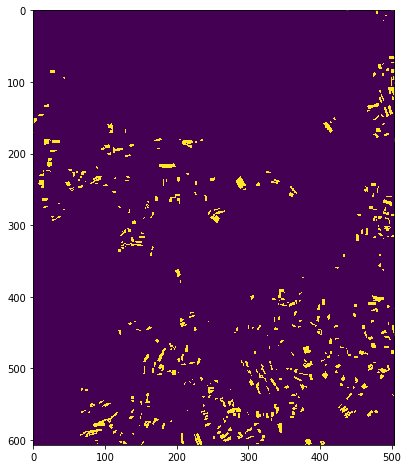

In [13]:
plt.figure(figsize=(8, 8))
plt.imshow(mask[...,0]>0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


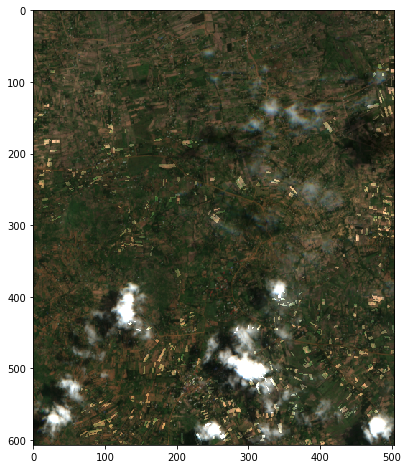

In [14]:
plt.figure(figsize=(8, 8))
plt.imshow(eopatch.data['S2-BANDS-L2A'][8][:,:,[3,2,1]] * (mask+1) * 2.5)

## Background extraction

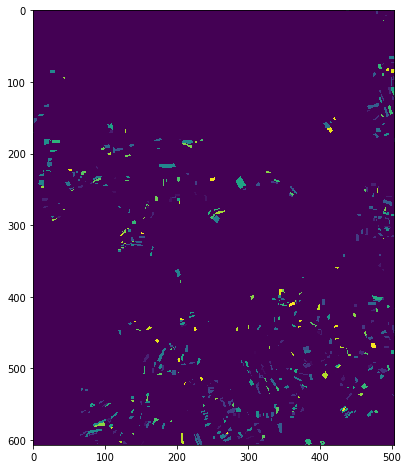

In [15]:
field_ids = eopatch.mask_timeless['FIELD_ID'][...,0]
plt.figure(figsize=(8, 8))
plt.imshow(field_ids)

In [16]:
from skimage.morphology import dilation, disk

In [17]:
field_id = 4794

In [18]:
def compute_bg_1(field_id):
    field_mask = (field_ids == field_id) * 1
    field_mask_d = dilation(field_mask, disk(3))
    field_mask_d = field_mask_d - field_mask
    
    return field_mask_d

In [19]:
%timeit compute_bg_1(field_id)

26.2 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
def extract_pixels(field_id):
    """ Extracts foreground (field) and background pixels for a given field_id """
    
    # TODO: neighborhood size parameter (dilation)
    
    field_mask = (field_ids == field_id) * 1

    xs, ys = np.where(field_mask)
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()

    # Cut out the window (speed up)
    # TODO: out of bounds check
    cropped_mask = field_mask[xmin-10:xmax+10, ymin-10:ymax+10]
    cropped_bands = eopatch.data['S2-BANDS-L2A'][:, xmin-10:xmax+10, ymin-10:ymax+10, :]
    
    cropped_mask_d = dilation(cropped_mask, disk(3))
    cropped_mask_d = cropped_mask_d - cropped_mask
    
    xs_bg, ys_bg = np.where(cropped_mask_d)
    xs_fg, ys_fg = np.where(cropped_mask)
    
    bg_pixels = cropped_bands[:, xs_bg, ys_bg, :]
    field_pixels = cropped_bands[:, xs_fg, ys_fg, :]
    
    return field_pixels, bg_pixels

In [27]:
%timeit extract_pixels(field_id)

3.81 ms ± 31.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
fg, bg = extract_pixels(field_id)

In [29]:
fg.shape, bg.shape

((13, 31, 12), (13, 88, 12))